# Compatibility

In [34]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# List physical devices
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.16.2
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [35]:
# Enable memory growth for the GPU

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [36]:
import json
import random
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Part 01: Pair Generation

In [37]:
metadata = pd.read_csv('../data/compatibility/metadata.csv')

In [38]:
metadata.head()

,id,type,group,pattern,group_color,perceived_color,index,section,garment_group,category,simplified_pattern,color_gategory
0,145872051,Top,Garment Upper body,Melange,Black,Black,Sport,Men H&M Sport,Jersey Fancy,upper_body,solid,neutral
1,150959011,Trousers,Garment Lower body,Solid,Black,Black,Sport,Men H&M Sport,Jersey Fancy,lower_body,solid,neutral
2,150959013,Trousers,Garment Lower body,Solid,Dark Grey,Grey,Sport,Men H&M Sport,Jersey Fancy,lower_body,solid,neutral
3,156289011,Trousers,Garment Lower body,Denim,Blue,Blue,Children Sizes 92-140,Kids Boy,Trousers Denim,lower_body,structured,cool
4,156610001,Trousers,Garment Lower body,Solid,Black,Black,Sport,Men H&M Sport,Jersey Fancy,lower_body,solid,neutral


## 1.1. Define Compatibility Rules

Define compatibility rules based on categories, patterns, colors, and occasions


In [39]:
# Category Compatibility
category_compatibility = {
    'upper_body': ['lower_body'],  # Tops pair with bottoms
    'lower_body': ['upper_body'],  # Bottoms pair with tops
    'one_piece': ['upper_body']  # Dresses pair with upper layers like sweaters
}

In [40]:
# Pattern Compatibility
def is_pattern_compatible(pattern1, pattern2):
    """
    Determines if two simplified patterns are compatible for pairing.
    """
    # Solids are compatible with any pattern
    if pattern1 == 'solid' or pattern2 == 'solid':
        return True
    
    # Identical patterns are not compatible
    if pattern1 == pattern2:
        return False
    
    # Printed patterns are generally compatible with structured patterns
    if (pattern1 == 'printed' and pattern2 == 'structured') or (pattern1 == 'structured' and pattern2 == 'printed'):
        return True

    # Printed patterns may clash with other printed patterns
    if pattern1 == 'printed' and pattern2 == 'printed':
        return False
    
    # Structured patterns can pair well with other structured patterns
    if pattern1 == 'structured' and pattern2 == 'structured':
        return True

    # Catch-all compatibility for patterns not explicitly handled
    return True


In [41]:
# Color Compatibility
def is_color_compatible(color1, color2):
    """
    Determines if two categorized colors are compatible for pairing.
    """
    # Neutral colors are compatible with any color
    if color1 == 'neutral' or color2 == 'neutral':
        return True

    # Metallic colors are generally compatible with all categories
    if color1 == 'metallic' or color2 == 'metallic':
        return True

    # Warm and cool colors are complementary
    if (color1 == 'warm' and color2 == 'cool') or (color1 == 'cool' and color2 == 'warm'):
        return True

    # Purples are versatile and compatible with warm, cool, and metallic colors
    if color1 == 'purple' or color2 == 'purple':
        if color1 in ['warm', 'cool', 'metallic'] or color2 in ['warm', 'cool', 'metallic']:
            return True

    # Identical colors (to avoid monotony)
    if color1 == color2:
        return True

    return False


In [42]:
# Occasion Compatibility
def is_occasion_compatible(index1, index2, garment_group1, garment_group2):
    # Items from the same index or garment group are more likely to pair well
    return index1 == index2 or garment_group1 == garment_group2

In [43]:
# Compatibility Function
def check_compatibility(item1, item2):
    """
    Check compatibility between two items based on rules.
    """
    # Category Compatibility
    if item2['category'] not in category_compatibility.get(item1['category'], []):
        return False

    # Pattern Compatibility
    if not is_pattern_compatible(item1['simplified_pattern'], item2['simplified_pattern']):
        return False

    # Color Compatibility
    if not is_color_compatible(item1['color_gategory'], item2['color_gategory']):
        return False

    # Occasion Compatibility
    if not is_occasion_compatible(
        item1['index'], item2['index'],
        item1['garment_group'], item2['garment_group']
    ):
        return True

    return True


## 1.2. Generate Pairs

In [44]:
batch_size = 32

In [45]:
embeddings = np.load('../data/embeddings/embeddings.npy')
labels = np.load('../data/embeddings/labels.npy')
paths = np.load('../data/embeddings/paths.npy')
ids = [path[-13: -4] for path in paths]

id_embeddings = {int(key): value for key, value in zip(ids, embeddings)}
id_embeddings

{772176001: array([9.9997866e-01, 5.0959788e-06, 3.7669361e-06, 4.4157914e-06,
        2.9029645e-06, 5.1730312e-06], dtype=float32),
 482199001: array([9.9997878e-01, 6.3437246e-06, 3.1271677e-06, 4.0784516e-06,
        2.3774589e-06, 5.3202884e-06], dtype=float32),
 799365027: array([9.9992037e-01, 2.1712700e-05, 1.5078049e-05, 1.4980485e-05,
        1.0635020e-05, 1.7304106e-05], dtype=float32),
 834229001: array([9.9994063e-01, 1.4772901e-05, 8.5775109e-06, 1.0790401e-05,
        7.1975737e-06, 1.8040833e-05], dtype=float32),
 469562065: array([1.00000000e+00, 9.56980539e-09, 7.33115701e-09, 1.03000115e-08,
        4.60073357e-09, 1.14458922e-08], dtype=float32),
 779341003: array([9.9999714e-01, 7.4519983e-07, 4.6107399e-07, 5.5872323e-07,
        3.2687464e-07, 7.7448851e-07], dtype=float32),
 837306001: array([9.9999678e-01, 9.1597758e-07, 5.0285098e-07, 6.0602156e-07,
        3.5777475e-07, 8.1563735e-07], dtype=float32),
 791746001: array([9.9999130e-01, 2.3806106e-06, 1.26171

In [46]:
def generate_pairs(metadata, id_embeddings, num_pairs):
    """
    Generate pairs of items with compatibility labels.
    """
    pairs = []
    labels = []

    for _ in range(num_pairs):
        
        # Randomly select two items
        item1 = metadata.sample(1).iloc[0]
        item2 = metadata.sample(1).iloc[0]

        img1 = id_embeddings[item1['id']]
        img2 = id_embeddings[item2['id']]

        # Check compatibility
        if check_compatibility(item1, item2):
            pairs.append([img1, img2])  # Label 1 for compatible
            labels.append(1)
        else:
            pairs.append([img1, img2])  # Label 0 for incompatible
            labels.append(0)

    return np.array(pairs), np.array(labels)

In [47]:
# Generate pairs
pairs, pairs_labels = generate_pairs(metadata, id_embeddings, num_pairs = 12000)


# Part 2: Build Compatibility Model

The goal is to learn a compatibility score between items using a Siamese Network or Triplet Network.

## 2.1. Siamese Network for Compatibility

In [48]:
model_path = '../models/best_model_after_finetune.keras'
feature_extraction_model = load_model(model_path)

In [67]:
# Define the input shape
input_shape = (6,)

# Define the base network
def create_base_network(input_shape):
    input_layer = layers.Input(shape = input_shape)
    x = layers.Dense(64, activation = 'relu')(input_layer)
    x = layers.Dense(32, activation = 'relu')(x)
    x = layers.Dense(16, activation = 'relu')(x)
    return models.Model(inputs = input_layer, outputs = x)

In [80]:
# Define the Siamese Network
def create_siamese_network(input_shape):

    base_network = create_base_network(input_shape)

    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    embedding_1 = base_network(input_1)
    embedding_2 = base_network(input_2)

    distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]), output_shape=(None, 16))([embedding_1, embedding_2])

    output = layers.Dense(1, activation = 'sigmoid')(distance)
    model = models.Model(inputs = [input_1, input_2], outputs = output)

    # Compile the model
    custom_lr = 0.0001
    adam = Adam(learning_rate = custom_lr)
    model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

# Siamese network model
siamese_model = create_siamese_network(input_shape)
siamese_model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_27      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_17       │ (None, 16)        │      3,056 │ input_layer_26[0… │
│ (Functional)        │                   │            │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, None, 16)  │          0 │ functional_17[0]… │
│                     │                   │            │ functional_17[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, None, 1)   │         17 │ lambda_7[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

## 2.3. Train the Siamese Network

Train the model using the generated pairs.

In [81]:
print(f'{pairs.shape=}')
input_1_pairs = pairs[:, 0, :]
input_2_pairs = pairs[:, 1, :]

pairs.shape=(12000, 2, 6)


In [82]:
history = siamese_model.fit([input_1_pairs, input_2_pairs], pairs_labels, epochs = 30, batch_size = 32)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7161 - loss: 0.6609
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8180 - loss: 0.6141
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8064 - loss: 0.5732
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8092 - loss: 0.5405
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8326 - loss: 0.5014
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8263 - loss: 0.4863
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8303 - loss: 0.4643
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8270 - loss: 0.4562
Epoch 9/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8309 - loss: 0.4348
Epoch 10/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8368 - loss: 0.4265
Epoch 11/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8247 - loss: 0.4222
Epoch 12/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

In [83]:
# Save the trained model
siamese_model.save('../models/siamese_model.keras')

# Part 3: Triplet Loss

The Triplet Loss ensures that embeddings for similar items are close and embeddings for dissimilar items are farther apart.

## 3.1. Define Triplet Loss


Custom triplet loss function:

In [ ]:
def triplet_loss(y_true, y_pred, margin=0.2):
    anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

    # Calculate the positive and negative distances
    pos_dist = K.sum(K.square(anchor - positive), axis = 1)
    neg_dist = K.sum(K.square(anchor - negative), axis = 1)

    # Compute the triplet loss with margin
    loss = tf.maximum(pos_dist - neg_dist + margin, 0)
    
    return tf.reduce_mean(loss)

## 3.2. Define Triplet Network

The Triplet Network takes three inputs: anchor, positive, and negative.


In [ ]:
class TripletModel(tf.keras.Model):
    def __init__(self, base_network):
        super(TripletModel, self).__init__()
        self.base_network = base_network

    def call(self, inputs):
        anchor, positive, negative = inputs
        anchor_embedding = self.base_network(anchor)
        positive_embedding = self.base_network(positive)
        negative_embedding = self.base_network(negative)


        return tf.stack([anchor_embedding, positive_embedding, negative_embedding], axis=1)

    def train_step(self, data):
        anchor, positive, negative = data


        with tf.GradientTape() as tape:
            embeddings = self.call((anchor, positive, negative))
            loss = triplet_loss(None, embeddings)

        grads = tape.gradient(loss, self.trainable_variables)

        # gradients
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {'loss': loss}

## 3.3. Prepare Training Data for Triplet Network

Generate triplets of (anchor, positive, negative) samples.

In [ ]:
print(f'{len(embeddings)=}')
print(f'{len(labels)=}')

len(embeddings)=6000
len(labels)=6000


In [ ]:
def create_triplets(embeddings, labels):
    triplets = []
    unique_labels = np.unique(labels)
    label_indices = {label: np.where(labels == label)[0] for label in unique_labels}

    for i in range(len(labels)):
        anchor = embeddings[i]
        positive_label = labels[i]
        negative_label = random.choice([label for label in unique_labels if label != positive_label])

        # Find a positive example
        positive_idx = random.choice(label_indices[positive_label])
        positive = embeddings[positive_idx]

        # Find a negative example
        negative_idx = random.choice(label_indices[negative_label])
        negative = embeddings[negative_idx]

        triplets.append([anchor, positive, negative])

    return np.array(triplets)

# Create triplets from embeddings and labels
triplets = create_triplets(embeddings, labels)

#the shape of the triplets
print(f"Triplets shape: {triplets.shape}")


Triplets shape: (6000, 3, 6)


## 2.4. Train the Triplet Network

Train using triplets:

In [ ]:
# Prepare the input data for training (anchor, positive, negative)
input_anchor_triplets = triplets[:, 0, :].reshape(-1, 6)
input_positive_triplets = triplets[:, 1, :].reshape(-1, 6)
input_negative_triplets = triplets[:, 2, :].reshape(-1, 6)

# Create and compile the triplet model
triplet_model = TripletModel(create_base_network((6,)))
triplet_model.compile(optimizer='adam')

# Create a TensorFlow dataset from the triplets
dataset = tf.data.Dataset.from_tensor_slices(
    (input_anchor_triplets, input_positive_triplets, input_negative_triplets)
).batch(32)

In [ ]:
# Train the model
history = triplet_model.fit(
    dataset,
    epochs = 10
)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0447
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0374
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0367
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0380
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0397
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0382
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0375
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0371
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0380
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0386


In [ ]:
triplet_model.save('../models/triplet_model.keras')

/Users/reem/Library/Mobile Documents/com~apple~CloudDocs/College/9th semester/CPCS-432/Project/vanilla/venv/lib/python3.11/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


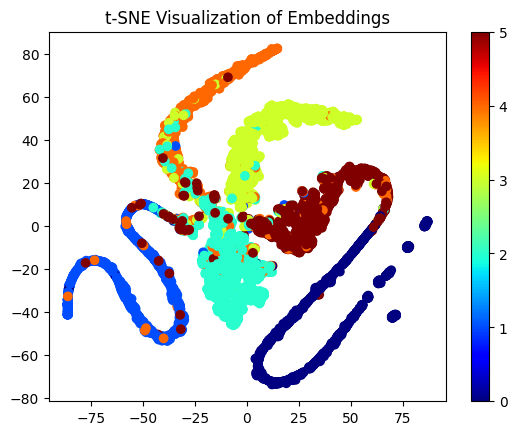

In [ ]:
data_embeddings = embeddings

# Apply t-SNE to the anchor embeddings
reduced_embeddings = TSNE(n_components = 2).fit_transform(data_embeddings)

# Visualize the reduced embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c = labels.astype(int), cmap = 'jet')
plt.colorbar()
plt.title("t-SNE Visualization of Embeddings")
plt.show()

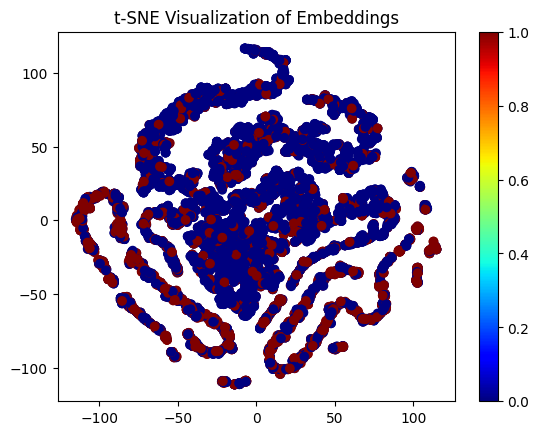

In [ ]:
anchor_embeddings = input_1_pairs

# Apply t-SNE to the anchor embeddings
reduced_embeddings = TSNE(n_components = 2).fit_transform(anchor_embeddings)

# Visualize the reduced embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c = pairs_labels.astype(int), cmap = 'jet')
plt.colorbar()
plt.title("t-SNE Visualization of Embeddings")
plt.show()

In [ ]:
# validation dataset or triplets:
val_triplets = create_triplets(embeddings, labels)

# Split into anchor, positive, negative
val_input_anchor = val_triplets[:, 0, :]
val_input_positive = val_triplets[:, 1, :]
val_input_negative = val_triplets[:, 2, :]

In [ ]:
# Create and compile the triplet model
triplet_model = TripletModel(create_base_network((6,)))
triplet_model.compile(optimizer='adam', loss=triplet_loss)

In [ ]:
# Extract anchor, positive, and negative triplets from the 'triplets' array
anchor_triplets = triplets[:, 0, :]
positive_triplets = triplets[:, 1, :]
negative_triplets = triplets[:, 2, :]

# Reshape the input triplets to match the expected input shape
anchor_triplets = anchor_triplets.reshape(-1, 6)
positive_triplets = positive_triplets.reshape(-1, 6)
negative_triplets = negative_triplets.reshape(-1, 6)

# Evaluate similarity for new triplets (anchor, positive, negative)
similarity_scores = triplet_model.predict([anchor_triplets, positive_triplets, negative_triplets])

# Print the first few similarity scores
print(similarity_scores[:5])

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[[ 0.39754763  0.26122478  0.01835758 -0.14388938 -0.03660072
   -0.21870145  0.345675   -0.2259324  -0.03115165  0.20018454
   -0.5563136   0.02957757  0.12207385  0.15506391 -0.28691563
    0.02673049]
  [ 0.3975487   0.26122633  0.01835794 -0.14388984 -0.03659976
   -0.21870278  0.34567678 -0.22593498 -0.03115098  0.20018728
   -0.55631834  0.02957813  0.12207516  0.15506582 -0.28691688
    0.02673032]
  [ 0.64204514  0.08922598  0.30879244 -0.23158431 -0.14792088
   -0.07831363  0.30505058 -0.04696602 -0.3537886  -0.01462689
    0.11506517  0.18426418 -0.09074999 -0.00212153 -0.19387352
    0.1721131 ]]

 [[ 0.39754844  0.26122522  0.01835811 -0.14388971 -0.03660077
   -0.21870181  0.34567538 -0.2259326  -0.03115198  0.20018475
   -0.556314    0.02957827  0.12207399  0.15506428 -0.28691602
    0.02673028]
  [ 0.39754847  0.26122645  0.01835768 -0.14388983 -0.03659972
   -0.21870306  0.3456768  -0.22593519 -0.03115068  0.2001875
   -0.556318

In [ ]:
# Save predictions to a JSON file
predictions = triplet_model.predict([input_anchor_triplets, input_positive_triplets, input_negative_triplets])
results = {'predictions': predictions.flatten().tolist(), 'true_labels': pairs_labels.tolist()}
with open('../models/triplet_model_results.json', 'w') as f:
    json.dump(results, f)

print("Results saved to triplet_model_results.json")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Results saved to triplet_model_results.json
